In [ ]:
import os
import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import itertools

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms

from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns
from tqdm.notebook import tqdm
torch.manual_seed(17)

import torch.optim as optim
import time
import copy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
device

device(type='cuda', index=0)

Google Colab commands

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset"
rs_chkpt_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/resnet/"

In [ ]:
train_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/train"
val_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/val"
test_path = "/content/drive/MyDrive/COVID-19_Radiography_Dataset/split_images/test"

Local commands

In [ ]:
dir_path = os.getcwd()
dir_path

'/home/eric/PycharmProjects/tfg/notebooks'

In [ ]:
proj_dir = os.path.dirname(os.getcwd())
print(proj_dir)

/home/eric/PycharmProjects/tfg


In [ ]:
train_path = proj_dir+"/split_images/train"
val_path = proj_dir+"/split_images/val"
test_path = proj_dir+"/split_images/test"

# Save/load model functions

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

# ResNet Transforms

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
}

In [ ]:
train_dataset = datasets.ImageFolder(
                              root = train_path,
                              transform = image_transforms["train"]
                       )

val_dataset = datasets.ImageFolder(
                              root = val_path,
                              transform = image_transforms["train"]
                       )

test_dataset = datasets.ImageFolder(
                              root = test_path,
                              transform = image_transforms["train"]
                       )

In [ ]:
print("Training length: ", len(train_dataset))
print("Validation length: ", len(val_dataset))
print("Testing length: ", len(test_dataset))

Training length:  11964
Validation length:  2279
Testing length:  910


In [ ]:
train_idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}
val_idx2class = {v: k for k, v in val_dataset.class_to_idx.items()}
test_idx2class = {v: k for k, v in test_dataset.class_to_idx.items()}

In [ ]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

Text(0.5, 1.0, 'Train Set Class Distribution')

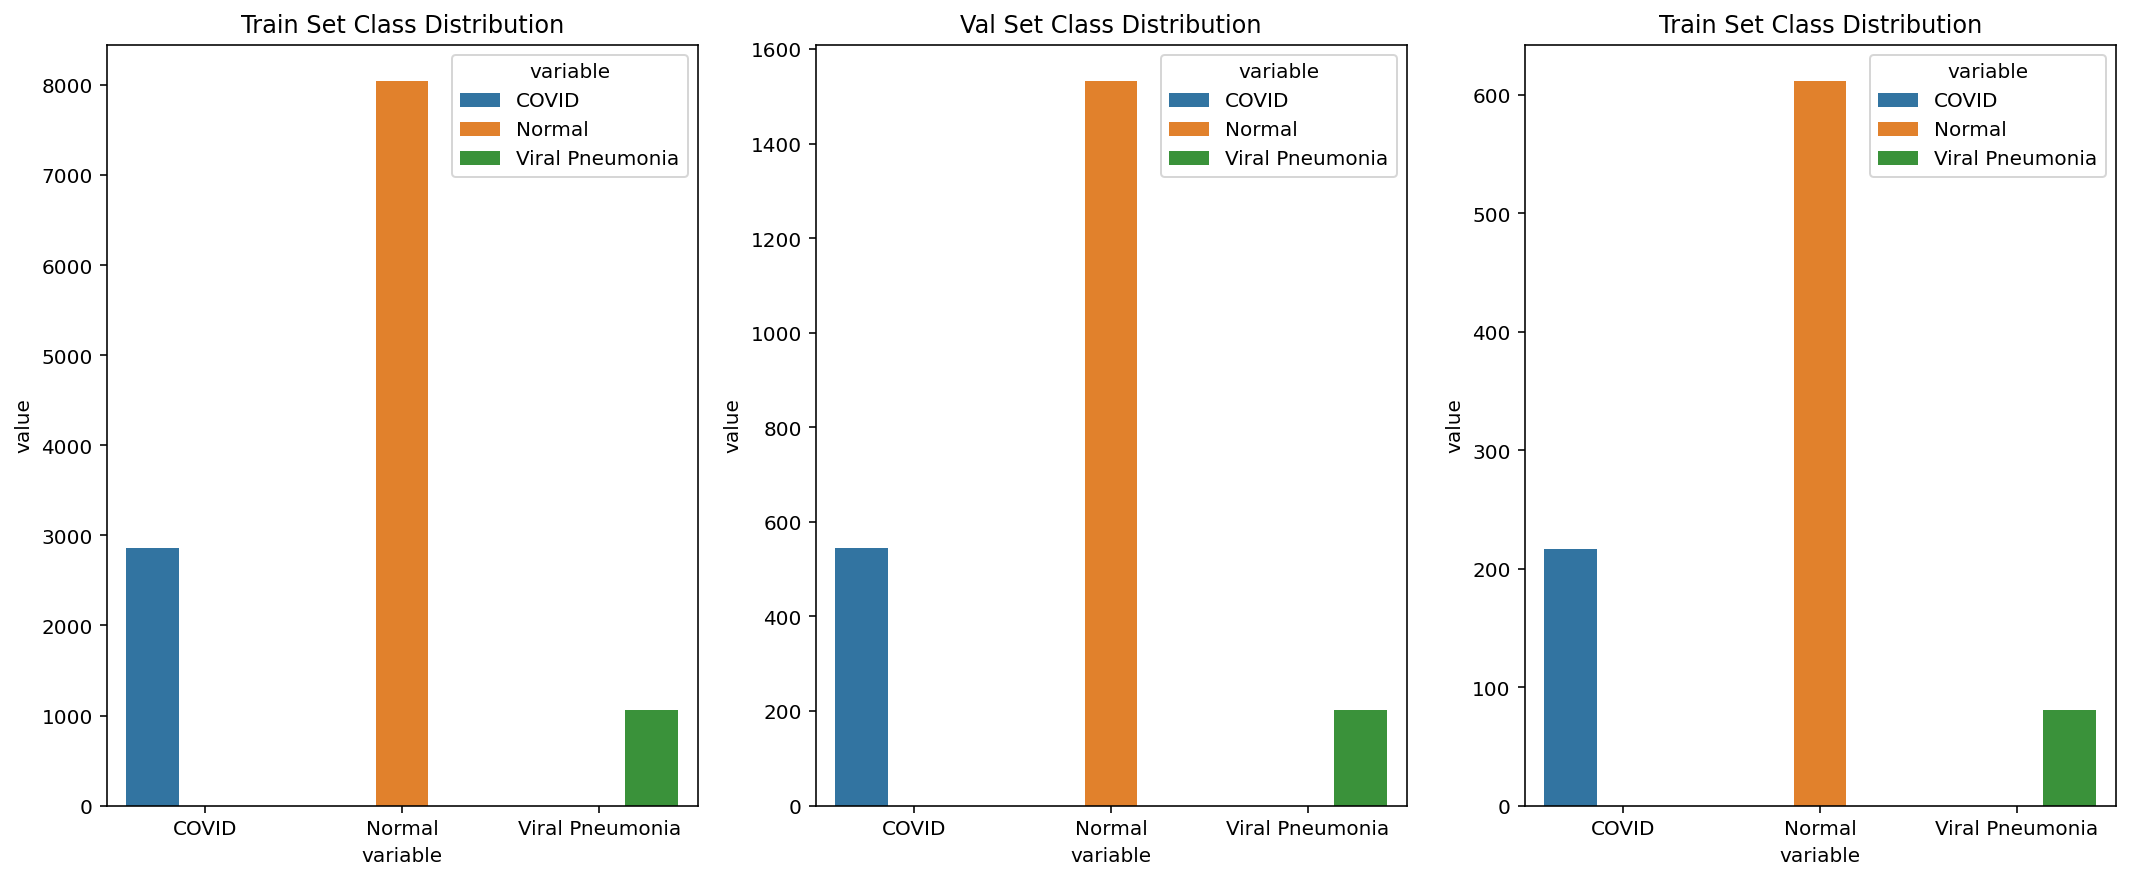

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_dataset, train_idx2class)]).melt(), x = "variable", y="value", hue="variable", ax=axes[0]).set_title('Train Set Class Distribution')

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_dataset, val_idx2class)]).melt(), x = "variable", y="value", hue="variable",ax=axes[1]).set_title('Val Set Class Distribution')

sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_dataset, test_idx2class)]).melt(), x = "variable", y="value", hue="variable",ax=axes[2]).set_title('Train Set Class Distribution')

In [ ]:
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=124, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_dataset, batch_size=124, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Evaluation Functions

In [ ]:
# Functions to create confusion matrix

def get_confusion_tensor(preds, targets):
  stacked = torch.stack(
      (
          torch.cat(targets, dim=0)
          ,torch.cat(preds, dim=0)
      )
      ,dim=1
  )
  cmt = torch.zeros(3,3, dtype=torch.int64)
  for p in stacked:
      tl, pl = p.tolist()
      cmt[int(tl), int(pl)] = cmt[int(tl), int(pl)] + 1
  return cmt

def plot_confusion_matrix(preds, targets, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  cm = get_confusion_tensor(preds, targets)

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, fontsize='large')
  plt.yticks(tick_marks, classes, fontsize='large')

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", fontsize='large', color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

# ResNet

In [ ]:
net = models.resnet18(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)



In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 3)
net.fc = net.fc.cuda() 

In [ ]:
def train_model(n_epochs, print_every):
  

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)    

  valid_loss_min = np.Inf
  loss_history=[]  
  correct_history=[]  
  val_loss_history=[]  
  val_correct_history=[]  
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  total_step = len(dataloader_train)
  for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(dataloader_train):
      net.train()
      data_, target_ = data_.to(device), target_.to(device)
      optimizer.zero_grad()
      
      outputs = net(data_)
      loss = criterion(outputs, target_)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _,pred = torch.max(outputs, dim=1)
      correct += torch.sum(pred==target_).item()
      total += target_.size(0)
      if (batch_idx) % print_every == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
      net.eval()
      for data_t, target_t in (dataloader_valid):
        data_t, target_t = data_t.to(device), target_t.to(device)
        outputs_t = net(data_t)
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_t, dim=1)
        correct_t += torch.sum(pred_t==target_t).item()
        total_t += target_t.size(0)
      val_acc.append(100 * correct_t/total_t)
      val_loss.append(batch_loss/len(dataloader_valid))
      network_learned = batch_loss < valid_loss_min
      print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
      if network_learned:
        valid_loss_min = batch_loss
        torch.save(net.state_dict(), rs_chkpt_path+'/'+str(n_epochs)+'_untrained_resnet.pt')
        print('Improvement-Detected, save-model')

    epoch_loss=running_loss/len(dataloader_train)
    epoch_acc=correct/total
    loss_history.append(epoch_loss)
    correct_history.append(epoch_acc)
    val_epoch_loss=batch_loss/len(dataloader_valid)
    val_epoch_acc=correct_t/total_t
    val_loss_history.append(val_epoch_loss)
    val_correct_history.append(val_epoch_acc)
      
  return loss_history, val_loss_history, train_acc, val_acc

# 15 epochs

In [ ]:
loss_history, val_loss_history, train_acc, val_acc = train_model(15, 20)

Epoch 1

Epoch [1/15], Step [0/374], Loss: 1.2450
Epoch [1/15], Step [20/374], Loss: 1.2029
Epoch [1/15], Step [40/374], Loss: 1.1105
Epoch [1/15], Step [60/374], Loss: 1.1240
Epoch [1/15], Step [80/374], Loss: 1.2401
Epoch [1/15], Step [100/374], Loss: 1.0458
Epoch [1/15], Step [120/374], Loss: 0.9938
Epoch [1/15], Step [140/374], Loss: 0.8276
Epoch [1/15], Step [160/374], Loss: 0.9383
Epoch [1/15], Step [180/374], Loss: 0.9313
Epoch [1/15], Step [200/374], Loss: 0.8114
Epoch [1/15], Step [220/374], Loss: 0.8744
Epoch [1/15], Step [240/374], Loss: 0.6478
Epoch [1/15], Step [260/374], Loss: 0.8401
Epoch [1/15], Step [280/374], Loss: 0.6169
Epoch [1/15], Step [300/374], Loss: 0.8886
Epoch [1/15], Step [320/374], Loss: 0.6212
Epoch [1/15], Step [340/374], Loss: 0.7068
Epoch [1/15], Step [360/374], Loss: 0.8886

train-loss: 0.9256, train-acc: 57.4891
validation loss: 0.6232, validation acc: 81.0443

Improvement-Detected, save-model
Epoch 2

Epoch [2/15], Step [0/374], Loss: 0.5456
Epoch [

# 20 Epochs

In [ ]:
loss_history, val_loss_history, train_acc, val_acc = train_model(20, 40)

Epoch 1

Epoch [1/20], Step [0/97], Loss: 1.3571
Epoch [1/20], Step [40/97], Loss: 0.7225
Epoch [1/20], Step [80/97], Loss: 0.5616

train-loss: 0.7599, train-acc: 64.7860
validation loss: 0.5710, validation acc: 75.2962

Improvement-Detected, save-model
Epoch 2

Epoch [2/20], Step [0/97], Loss: 0.6049
Epoch [2/20], Step [40/97], Loss: 0.4452
Epoch [2/20], Step [80/97], Loss: 0.4445

train-loss: 0.6263, train-acc: 81.5028
validation loss: 0.5002, validation acc: 85.0812

Improvement-Detected, save-model
Epoch 3

Epoch [3/20], Step [0/97], Loss: 0.4110
Epoch [3/20], Step [40/97], Loss: 0.3868
Epoch [3/20], Step [80/97], Loss: 0.3208

train-loss: 0.5438, train-acc: 87.9806
validation loss: 0.4479, validation acc: 89.6446

Improvement-Detected, save-model
Epoch 4

Epoch [4/20], Step [0/97], Loss: 0.3894
Epoch [4/20], Step [40/97], Loss: 0.3128
Epoch [4/20], Step [80/97], Loss: 0.3269

train-loss: 0.4844, train-acc: 90.8893
validation loss: 0.4074, validation acc: 91.6191

Improvement-Detec

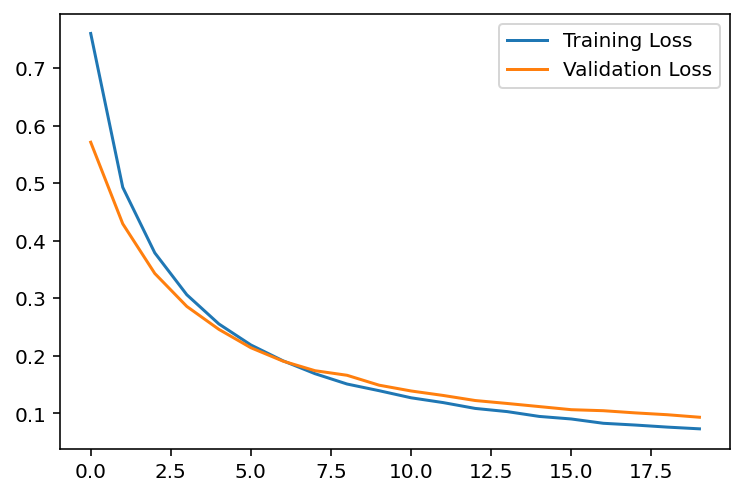

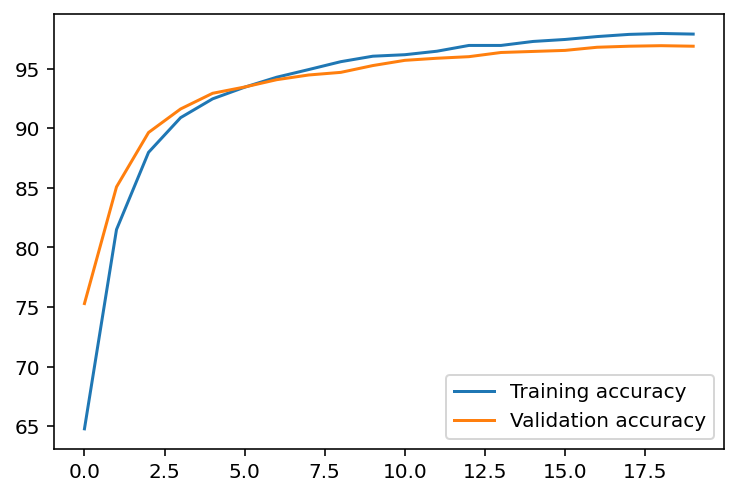

In [ ]:
plt.plot(loss_history,label='Training Loss')  
plt.plot(val_loss_history,label='Validation Loss')  
plt.legend()  
plt.show()  
plt.plot(train_acc,label='Training accuracy')  
plt.plot(val_acc,label='Validation accuracy')  
plt.legend()  
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plot_confusion_matrix(all_preds, all_labels, test_dataset.classes)

NameError: ignored

<Figure size 432x432 with 0 Axes>